**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Genre classification with support vector machine*

>[Music genre classification](#scrollTo=v5BL7AexPm-I)

>>[Abstract](#scrollTo=BxJ94ttZPm-J)

>>[Introduction](#scrollTo=5WWadihrPm-L)

>>[Data analysis](#scrollTo=dSBZ-0SiPm-N)

>>[Methods and experiments](#scrollTo=K7nkl4ovPm-h)

>>>[3.1 Preprocessing](#scrollTo=4VXSfdJZPm-i)

>>>[3.2 Classifier](#scrollTo=50lvY910Pm-r)

>>[Results](#scrollTo=bMtD5GNhPm-y)

>>[Discussion/Conclusions](#scrollTo=uISnje_0Pm_C)

>>[References](#scrollTo=k0O-_BrWPm_E)

>>[Appendix](#scrollTo=zS59fnjFPm_I)



## Abstract

In this project our intent is to formulate an implementation of music classification to genres using machine learning techniques. A standard procedure before analyzing audio signals is decomposing the audio. Before the classification, the classifiable song needs to be preprocessed by extracting some distinct characteristics. The songs are decomposed to three different categories - rhythm patterns, chroma and mel frequency cepstral coefficients (MFCCs), which make up the feature space of the model. After the initial feature mapping, some additional features are computed that include variance, maximum, minimum and mean values of the three categories and added to the feature vector. Using these features the classification is implemented with C-support vector classification (SVC), which is first trained with provided labeled data and later used to predict labels of unlabeled data, that is,  predicting which of the 10 music genres considered in the project the songs belong to. The final fitted SVC classifier yielded prediction accuracies of approximately 66%.

## 1. Introduction

Dividing music to genres is an usual way of categorizing music since it comes in all different shapes and sizes. Musical genres shares some charasteristic features which include for instance rhythm patterns, timbre and  spectral qualities. 

Nowadays with growing music streaming platforms with new music flooding in around the clock, a convenient way of organizing and managing music is by categorizing it by its genre. Nevertheless, as no one can keep up with the amount of new music rushing to the market and that is where a genre classifier software would come in handy. Categorizing music by its genre helps for example the service provider to offer more specific and personalized music to the users and makes it easier for the users to find the kind of music they like. However, classifying a song solely on its tonal and rhytmic qualities is a rather hard task to do since there is no definite boundaries between different genres of music. 

The charasteristics we use in this project for genre classification are rhythm patterns, chroma and MFCCs. Chroma values depict the melody and harmony of the song and consist of 12 classes, one for each semitone, and 4 statistics. The rhythm pattern values consist of how much frequency modulation on specific range of the spectrum is happening and is represented by 24 different bands and 7 statistics. MFCCs are a way of describing the timble of a audio sample. To obtain the MFCCs, the audio is fourier transformed and mapped to mel scale which is then again transformed using discrete cosine transform. The resulting amplitudes are the mel frequency cepstral coefficients. The first 12 MFCCs with 4 statistics are inlcuded in the feature vector. Combining all the features we end up with a 264 dimensional feature vector [1].

The goal is to map each feature vector to the correct corresponding label. We implement a model which takes a feature vector as input and returns a vector with its value correspong to probability of the input song belonging to  each genre. The label space consist of most common 10 genres which are numbered from one to ten:

1. Pop_Rock

2. Electronic

3. Rap

4. Jazz

5. Latin

6. RnB

7. International

8. Country

9. Reggae

10. Blues

In section 2 we overview the given dataset and preprocess the feature vectors to a more suitable format. The classifier and other methods used in this project are described and evaluated in section 3 and in section 4 we present the results.



## 2. Data analysis

Firstly we import all the necessary libraries. The libraries include Scikit-learn (abbreviated sklearn) which is a machine learning library that contains all the required preprocessing and classification algorithms,  NumPy, a essential library for mathematical functions and matrix calculations, Pandas for data manipulation and finally, matplotlib for plotting.

After importing the data we can check its dimensions - the feature matrices $ F \in \mathbb{R}^{n \times 264}$ consist of $n$ 264 dimensional feature vectors as stated before, where $n$ denotes the number of entries and is 4363 for the train data and 6544 for the test data. The train label data is accordingly a 4363 values long vector with its values beging integers ranging from 1 to 10.  
As we plot the train labels to a bar chart, a major imbalance is noticable. Class 1 entries make up about half of the train data whereas classes 9 and 10 have under 100 occurrences. Also, the range of feature vector values is rather spread out as calulated below the bar chart. These facts make the classification more challenging and need to be taken into account in data preprocessing.





In [1]:
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
df_data=pd.read_csv('train_data.csv',header=None)
df_label=pd.read_csv('train_labels.csv',header=None)
df_test=pd.read_csv('test_data.csv',header=None)
labels=df_label.values[:,0]
features=df_data.values
test_features=df_test.values

print(features.shape)
print(test_features.shape)
print(labels.shape)

(4363, 264)
(6544, 264)
(4363,)


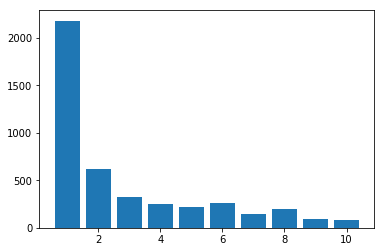

Number of occurrences of each label:  [2178  618  326  253  214  260  141  195   92   86] 

Mean of maximum values of feature vectors:  1000000.0 
Mean of minimum values of feature vectors:  -40.282629966765995


In [4]:
values, counts = np.unique(labels, return_counts=True)
plt.bar(values, counts)
plt.show()
print("Number of occurrences of each label: ",counts, "\n")
print("Mean of maximum values of feature vectors: ", sum(np.max(features[i,:]) for i in range(len(features)))/len(features), 
     "\nMean of minimum values of feature vectors: ",sum(np.min(features[i,:]) for i in range(len(features)))/len(features))

### 2.1 Data visualization

To understand the classification problem better we needed to visualize the data. This was first done using principal component analysis (PCA). PCA didn't really seem to give different components for different genres in two dimensions. This happens probably as a result of differences between genres being really narrow. For better understanding we used t-distributed stochastic neighbor embedding (tSNE) which basicly maps featurevectors with similar properties closer to eachother and dissimilar futher away from eachother on two dimensional plane.

From mapping we noticed that genres had huge overlapping areas. Some genres like international and blues are evenly distributed across whole featurespace. This would make giving preditions extremely hard and finding accurate method impossible. For our relief there is huge areas with distinct majority genre.

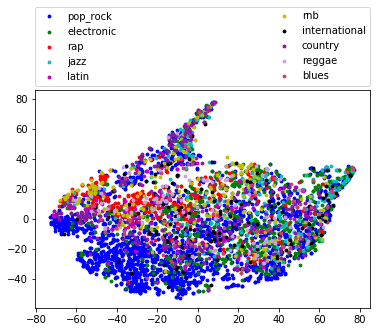

In [5]:
#dimensionality reduction for enhanced tSNE grouping
pca=PCA(n_components=20).fit_transform(features)
#project groups to 2d plane
#this can take a while
stochaistic_neighbors=TSNE(n_components=2).fit_transform(pca)

music_by_category=[]
for i in range(0,10):
    music_by_category.append([])
for i in range(0,len(features)):
    music_by_category[labels[i]-1].append(np.asarray(stochaistic_neighbors[i]))
  
names=['pop_rock','electronic','rap','jazz','latin','rnb','international','country','reggae','blues']
colors=['b', 'g', 'r', 'c', 'm', 'y', 'k','#7e1e9c','#c79fef','#cb416b']

for i in range(0,len(music_by_category)):
    plt.scatter(np.transpose(music_by_category[i])[0],np.transpose(music_by_category[i])[1],c=colors[i],s=8,label=names[i])

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.show()

## 3. Methods and experiments

### 3.1 Preprocessing

With the range of feature vectors' values varying widely, a normalization of the feature vectors is a good way of improving the performance of ML algorithms. An common way of implementing the normalization is a min-max scaler or by using a sigmoid function. However, with our data with the feature values ranging from minimum of about -1700 and maximum of $10^6$, these functions would "squishify" the smaller end values too aggressively such that the many of the data points would become next to useless. That's why we ended up using sklearn's quantile transformer to normalize our data. The scaler transforms the features to a uniform distribution between zero and one. The transformation is applied to each feature independently and it tends to spread the most frequent values with also reducing the impact of outliers, which is also a good way of noise cancellation [5].

After the normalization, a set of additional features are added to each feature vector. The added features include the mean, minimum and maximum values as well as variance for each statistic of all the three different charcteristics (rhythm, chroma and MFCCs) in the feature space.

We also tried feature reduction. Performing PCA seemed to lower the accuracy score. Analyzing out-of-bag (OOB) error of random forest decision trees or boosted trees showed that almost third of the data didn't have a noticeable effect on prediction accuracy. The accuracy of our models didn't improve after removing unnecessary features. This was a bit unexpected but it showed that our model wasn't overfitting to these features. Also removing features didn't decrease computational complexity significantly. However, we ran into problems between training sessions since we used $10^{-3}$ as significance cutoff. Due to random change significance using OOB error of features was a bit different between sessions. This resulted in varying lengths of feature vectors. Because of this would have had to fine tune model parameters between each session. We decided that it was easier to just use all features.

Finally, the features and labels are shuffled in case of the data is ordered in some way which might affect the behaviour of the classifier.


In [6]:
def scale_features(x):
    quantile_transformer = QuantileTransformer(random_state=0, n_quantiles=100, output_distribution="uniform")
    features= quantile_transformer.fit_transform(x)
    return features, quantile_transformer

def added_features(x):
    xi=[]
    for i in range(0,len(x)):
        feature_collector=[]
        #append all rythm statistics
        for j in range (0,168,24):
            rythm=np.median(x[i,j:j+24])
            mean_rythm=np.mean(x[i,j:j+24])
            var_rythm=np.var(x[i,j:j+24])
            min_rythm=np.min(x[i,j:j+24])
            max_rythm=np.max(x[i,j:j+24])
            feature_collector.append(rythm)
            feature_collector.append(var_rythm)
            feature_collector.append(mean_rythm)
            feature_collector.append(min_rythm)
            feature_collector.append(max_rythm)
            
        #append all chroma statistics
        for j in range(168,216,12):
            chroma=np.median(x[i,j:j+12])
            mean_chroma=np.mean(x[i,j:j+12])
            var_chroma=np.var(x[i,j:j+12])
            min_chroma=np.min(x[i,j:j+12])
            max_chroma=np.max(x[i,j:j+12])
            feature_collector.append(chroma)
            feature_collector.append(mean_chroma)
            feature_collector.append(var_chroma)
            feature_collector.append(min_chroma)
            feature_collector.append(max_chroma)
            
        #append mfcc
        feature_collector.append(np.median(x[i,216:246]))
        feature_collector.append(np.min(x[i,216:246]))
        feature_collector.append(np.max(x[i,216:246]))
        feature_collector.append(np.var(x[i,216:246]))
        
        xi.append(np.concatenate((feature_collector,x[i]),axis=None))
    return np.asarray(xi)

After normalizing and adding the features, the values are normalized between zero and one, and the dimesion of the feature matrix space $F$ has grown to $\mathbb{R}^{n \times 323}$.

In [7]:
features=added_features(features)
features,labels=sklearn.utils.shuffle(features,labels)
print(features.shape)

(4363, 323)


### 3.2 Classifier

Choosing the right estimator for the problem was a difficult task since the number of different estimators is vast. However, since we were predicting a category and had access to labeled training data, the most reasonable estimator should be a classifier rather than a regressor or a clustering algorithm [2]. As Naive Bayes classifier is good for text data and SDG classifier as well as kernel approximation are good methods for a much larger sample sizes, we ended up experimenting with KNeighbors, random forest and SVC classifiers.

First we determined data's baseline accuracy using random
 forest classifier. It gave varying results above 60% accuracy. KNeighbors classifier yielded roughly equal acccuracies, but with SVC classifier there was a noticable difference in the accuracy using the SVC's default kernel type. The kernel type of the SVC classifier can be chosen from four different kernels: linear, polynomial, sigmoid or radial basis function.

In [8]:
#distinct transformation using pipeline to avoid data leakage before cross validation
transform=QuantileTransformer(random_state=0, n_quantiles=100, output_distribution="uniform")
#you might want to tweak cache_size based on your hardware
model=svm.SVC(kernel='rbf',C=12,gamma=0.0072, cache_size=2000, decision_function_shape='ovo')
clf=make_pipeline(transform,model)

Chosen RBF kernel basically creates decision boundaries based on radial function. Effective parameters for our model accuracy are gamma and C. Models parameter gamma represents the radial effect of single data point. The low value means single datapoints effectivity is distributed to a larger area in hyperspace. High value means that the data points effect is more closely distributed. C parameter is used in the training phase. Large C yield accurate results for training set but is more prone to overfitting.[3]

Since there is no way to tell certainly which are the best parameters finding the right parameters estimator requires a lot of iterating. As we noticed in data visualization data is really noisy so we can suppose that C is quite small. To find right magnitudes for parameters we iterated over magnitudes of parameters. After those right parameters were found we grid searched for optimal values within the chosen magnitude of parameters.

In [9]:
#DISCLAIMER. PLEASE DON'T RUN ON AVARAGE COMPUTER. ESPECIALLY ON JUPYTERHUB

supportvm = svm.SVC(kernel='rbf',cache_size=7000, decision_function_shape='ovo')
parameters={'gamma':(0.001,0.01,0.1,1,10),'C':(0.1,1,10,100)}
#cv=10 to reduce the chance of random peak during validation
search = GridSearchCV(supportvm, parameters,cv=10)
search.fit(features,labels)
search.best_params_

KeyboardInterrupt: 

## 4. Results

Accuracy of the model's predictions is calculated

$accuracy(y,y_p)= \frac{1}{N} \sum_{i=1}^{N}  y_{p,i}=y_{i}$, where  the equality yields 1 if the values are equal and 0 otherwise, and $N$ is the number of samples.

Log-loss $L$ is used to evaluate the probability outputs of the classifier which indicate in a sense how "certain" the model is of its classification. The log-loss is calculated
$L= -\frac{1}{N} \sum_{i=1}^{N}  \sum_{k=1}^{K} y_{i,k} log (p_{i,k})$  


The accuracies computed with the results of cross validation with 5 splits were approximately 66% which were nearly the same what Kaggle gave for test data within one percent. The log loss value that was calculated with split train data yielded much larger values than what we got from Kaggle with the test data which was a mystery for us.





In [10]:
y_p=cross_val_predict(clf,features, labels.ravel(), cv=5)
accuracy=accuracy_score(labels,y_p)
print("Accuracy of cross validation: ",accuracy)


#A new classifier with the "probability" parametre True
clf=svm.SVC(kernel='rbf',C=12,gamma=0.0072, cache_size=5000, probability=True)

X_train, X_test, y_train, y_test = train_test_split(features, labels.ravel(), test_size=0.3)
X_train, trans=scale_features(X_train)
clf.fit(X_train,y_train)
probability_test=clf.predict_proba(trans.transform(X_test))
print("Log loss: ", log_loss(y_test, probability_test))

Accuracy of cross validation:  0.6733898693559477
Log loss:  1.0474352237223608


By looking at confusion matrix we see that the most false predictions are other genres indentifying as pop_rock. This happens due to pop_rock being really diverse genre and majority genre in dataset. We tried to combat this with variety of methods. First we tried undersampling by picking random datapoint from majority genres. This vastly decreased the accuracy. Next, we tried oversampling by adding additional point linearly between minority genres. This actually increased accuracy for some genres. However overall accuracy vastly decreased since some minority genres which were scattered all over feature space got over-represented in predictions. For the last method, we tried reducing majority genres by removing data points of other genres near minority genres. This is so called Tomek links method. This sampling actually resulted in really good models. If predictions were made for evenly distributed set of genres models accuracy would have been beyond our current model. However, this model falsely predicts some of pop_rock datapoint to other genres. This huge disbalance in features led us to stick to predicting with given data.

In [15]:
clf=svm.SVC(kernel='rbf',C=12,gamma=0.0072, cache_size=5000)

X_train, X_test, y_train, y_test = train_test_split(features, labels.ravel(), test_size=0.3)
X_train, trans=scale_features(X_train)
clf.fit(X_train,y_train)
sklearn.metrics.confusion_matrix(y_test,clf.predict(trans.transform(X_test)))

array([[591,  33,   4,   6,   3,  11,   0,   8,   2,   0],
       [ 54, 108,   8,   2,   3,   1,   0,   0,   1,   0],
       [ 15,   6,  66,   0,   1,   5,   0,   0,   0,   0],
       [ 34,   4,   1,  39,   0,   6,   0,   0,   1,   0],
       [ 45,   4,   2,   0,   9,   4,   1,   2,   1,   0],
       [ 31,   3,   7,   2,   0,  29,   0,   1,   1,   0],
       [ 30,   4,   1,   2,   1,   1,   1,   0,   1,   0],
       [ 31,   0,   0,   3,   0,   3,   1,  19,   0,   0],
       [  5,   1,   3,   0,   2,   4,   1,   1,  10,   0],
       [ 22,   0,   1,   3,   0,   1,   0,   0,   0,   2]])

## 5. Discussion/Conclusions

What we found predicting music genres is hard. Using data we got it's too hard to predict the genre for practical usage. 

Since predicted dataset seems to be imbalanced the model with the best accuracy and logloss score won't be best for classifying evenly distributed genres. In other words, the probability of music being pop_rock in the first place leads to probability of genre being pop_rock be higher. Resulting higher accuracy on evenly distributed dataset tells us that it's easier to distinguish other genres from eachother than pop_rock from other genres.

In similar studies, accuracy of predictions has been around same size. [4] They also tried similar machine learning methods such as support vector machines. However, none of the studies we found used RBF kernel which we found to be the most effective. Also, they used GTZAN dataset which contains small music clips and preprosessed them theirselves. This allowed them to have more freedom in feature engineering which opens more possibilities for better results.

To improve accuracy we could use same oversampling methods as discussed in results but just ignore genres without distinct characteristics. This could result in much higher accuracy between remaining genres and higher accuracy overall.



## 6. References

[1] MLBP 2018 Data Analysis Project - Problem Description

[2] [Scikit learn - Choosing the rigth estimator](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

[3] [Scikit learn - RBF SVM parameters](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py)

[4] [Genre classification and the invariance of MFCC
features to Key and Tempo](https://pdfs.semanticscholar.org/5767/70606d61a746412c39c39a839bbb5228b9ac.pdf)
and [Music Genre Classification Using MFCC, K-NN
and SVM Classifier](https://pdfs.semanticscholar.org/c9fe/6a0d9074f8271fce120a00549c3f81d24824.pdf)

[5] [Scikit learn - Quantile Transformer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html)
